<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/objsubclass/colab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!rm -rf vgg16obj
!git clone https://github.com/soukhind2/vgg16obj


Cloning into 'vgg16obj'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 86 (delta 41), reused 52 (delta 22), pack-reused 0
Unpacking objects: 100% (86/86), done.


In [3]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class

In [4]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools





In [5]:
def convertimgs(path,data) :
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            im = preprocess_input(im)
            data.append(im) 
    return data


train_it = []
train_it = convertimgs('/content/data_6class/train/faces/Male',train_it)
train_it = convertimgs('/content/data_6class/train/faces/Female/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Manmade/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Natural/',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Powered',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Nonpowered',train_it)
train_it = np.array(train_it)

val_it = []
val_it = convertimgs('/content/data_6class/val/faces/Male/',val_it)
val_it = convertimgs('/content/data_6class/val/faces/Female/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Manmade/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Natural/',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Powered',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Nonpowered',val_it)
val_it = np.array(val_it)

test_it = []
test_it = convertimgs('/content/data_6class/test/faces/Male/',test_it)
test_it = convertimgs('/content/data_6class/test/faces/Female/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Manmade/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Natural/',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Powered',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Nonowered',test_it)
test_it = np.array(test_it)

print(train_it.shape,val_it.shape,test_it.shape)


(1554, 224, 224, 3) (150, 224, 224, 3) (162, 224, 224, 3)


In [6]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [244,244,3])
#plot_model(model,show_shapes=True,expand_nested=True)

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_val = model.predict(val_it) 
print(f'Val Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')

     
#np.save('features_train' , features_train)
#np.save('features_val', features_val)
#np.save('features_test', features_test)

Train Time: 15.277242183685303
Val Time: 1.8736588954925537
Test Time: 1.1823716163635254


In [9]:
epochs = 30

#train_data = np.load('features_train.npy')
train_data = features_train
#train_labels = [0] * 250 + [1]*250 + [2] * 250 + [3] * 250 + [4] * 275 + [5] * 279
#train_labels = [0] * 250 + [1]*250 + [0] * 250 + [1] * 250 + [0] * 275 + [1] * 279
train_labels = [0] * 250 + [0]*250 + [1] * 250 + [1] * 250 + [2] * 275 + [2] * 279
train_labels = to_categorical(train_labels, 3)


#val_data = np.load('features_val.npy')
val_data = features_val
#val_labels = [0] * 25 + [1]*25 + [2] * 25 + [3] * 25 + [4] * 25 + [5] * 25
#val_labels = [0] * 25 + [1]*25 + [0] * 25 + [1] * 25 + [0] * 25 + [1] * 25
val_labels = [0] * 25 + [0]*25 + [1] * 25 + [1] * 25 + [2] * 25 + [2] * 25
val_labels = to_categorical(val_labels, 3)

#test_data = np.load('features_test.npy')
test_data = features_test
#test_labels = [0] * 50 + [1] * 50 + [2] * 50
#test_labels = [0] * 61 + [1] * 40 + [2] * 61
#test_labels = [0] * 31 + [1]*30 + [2] * 19 + [3] * 21 + [4] * 31 + [5] * 30
#test_labels = [0] * 31 + [1]*30 + [0] * 19 + [1] * 21 + [0] * 31 + [1] * 30
test_labels = [0] * 31 + [0]*30 + [1] * 19 + [1] * 21 + [2] * 31 + [2] * 30
test_labels = to_categorical(test_labels, 3)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

input = keras.Input(shape= train_data.shape[1:])
x = layers.Flatten()(input)
x = layers.Dense(4096, activation="relu")(x)

#branch1
b1 = layers.Dense(1024, activation="relu")(x)
o1 = layers.Dense(2,activation="softmax")(b1)

#branch2
b2 = layers.Dense(1024, activation="relu")(x)
o2 = layers.Dense(3,activation="softmax")(b2)


#outputs = layers.Dense(6,activation="softmax")(x)
model1 = keras.Model(inputs=input, outputs=o1)
model2 = keras.Model(inputs=input, outputs=o2)



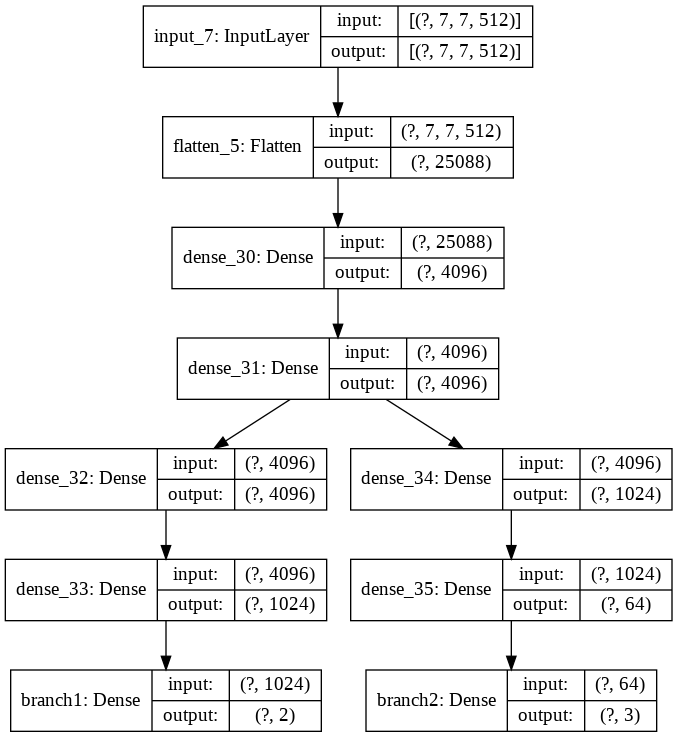

In [17]:
from vgg16obj.tools import objnet
model = objnet.modelarch().build_full_model([7,7,512] ,
                                 stem_len = [4096,4096],
                                 b1_len = [4096,1024],
                                 b2_len = [1024,64]
                                 )
plot_model(model,show_shapes=True,expand_nested=True)

In [18]:
'''
model = Sequential()

model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(4096, activation='relu')) 
##model.add(Dropout(0.5)) 
model.add(Dense(6, activation='softmax'))
model.summary()
'''



model.compile(optimizer= Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model2.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=64,
          validation_data=(val_data, val_labels),
          verbose = 1, callbacks = [es])
#model.save_weights('top_weights',overwrite = True)



NameError: ignored

In [ ]:
out = model2.evaluate(test_data,test_labels)
print(out)

pred = np.round(model2.predict(test_data),0)
#print('rounded test labels',pred)

In [ ]:
classes = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
metric = metrics.classification_report(test_labels,pred,target_names = classes)
print(metric)


In [ ]:
from vgg16obj.tools import plot_tools as pt
pt.plot_metrics(history)

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels, categorical_preds)

pt.plot_confusion_matrix(cm,classes,normalize = False)

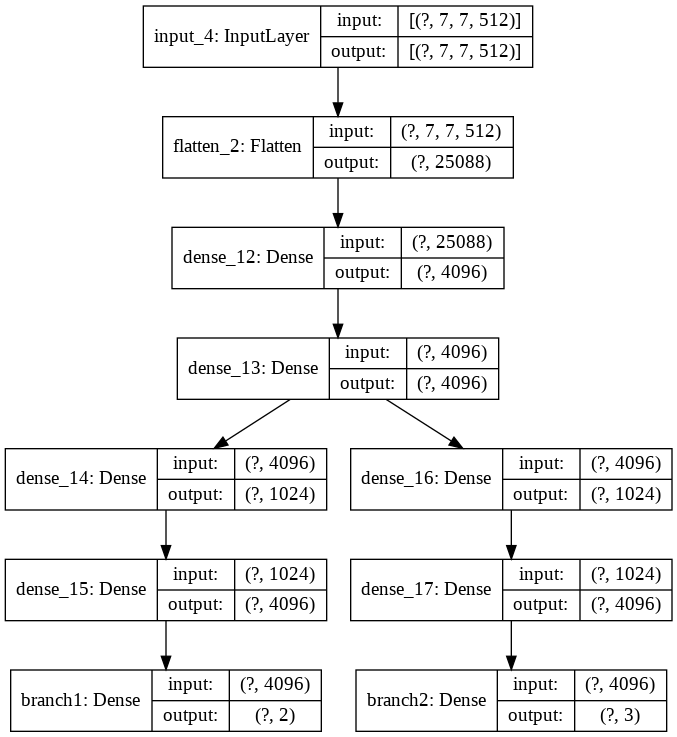

In [14]:
plot_model(model,show_shapes=True,expand_nested=True)